# Task: Improve Accuracy

The task is to improve the accuracy from 90% to 98-99%. Densenet161 gives 90% accuracy. The task is to optimize for accuracy but I will also show the F Beta score of the model as well. This notebook will feature a vgg16 model, trained in fastAI, and using progressive resizing and cutout to attain better results.

The model only manages to achieve 95% accuracy, so I would consider this model a large step in the right direction, but not quite reaching the destination. Feel free to fork this notebook and play around, maybe you will find the missing link to reach the 98%+ mark. Check my final thoughts section for ideas for further improvement

Special Thanks to:
* Sarvesh Dubey for both the dataset and the Task https://www.kaggle.com/tourist55

In [1]:
import numpy as np
import pandas as pd
import os
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai import *
from fastai.vision import *

torch.Size([3, 208, 176])


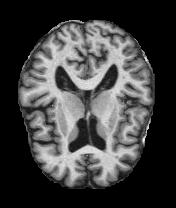

In [2]:
img = open_image(Path('//kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train/VeryMildDemented/verymildDem972.jpg'))
print(img.shape)
img

In [3]:
PATH = Path('/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/')


### Cutout
Cutout is a method for removing small chunks of an image at random (see the batch images below to get an idea). This was one of the transforms that I experimented the most with and it helped close the gap a little between validation accuracy and test accuracy. 

In [4]:
transform = get_transforms(max_rotate=7.5, max_zoom=1.15, max_lighting=0.15, max_warp=0.15, p_affine=0.8, p_lighting = 0.8, 
                           xtra_tfms= [pad(mode='zeros'), symmetric_warp(magnitude=(-0.1,0.1)), cutout(n_holes=(1,3), length=(5,5))])

### Pint sized model

Progressive Resizing involves pretraining a model on shrunken versions of images (in this case, down to size 112x112) and then retraining the model on the full sized images (or possibly a few intermediate sized images in between if we want to get excessive).

In [5]:
data = ImageDataBunch.from_folder(PATH, train="train/",
                                  test="test/",
                                  valid_pct=.4,
                                  ds_tfms=transform,
                                  size=112,bs=32, 
                                  ).normalize(imagenet_stats)

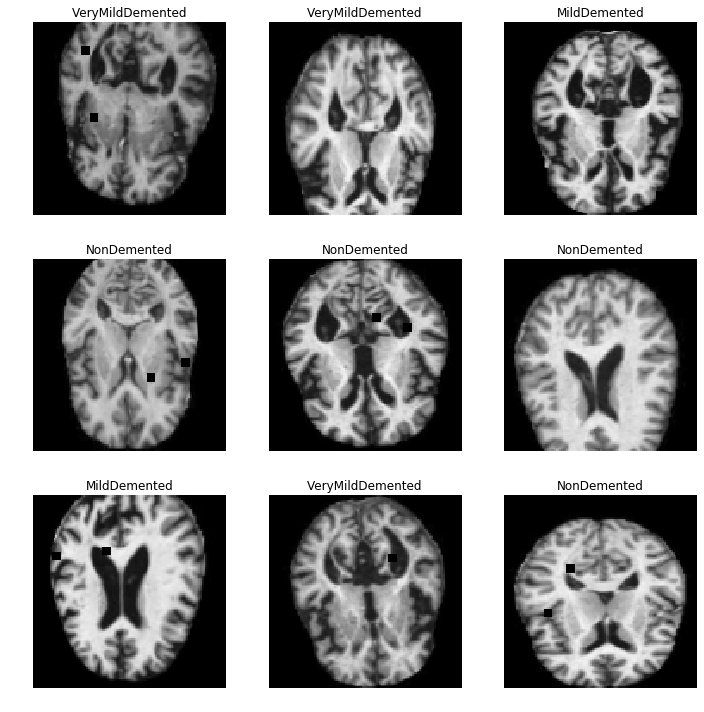

In [6]:
data.show_batch(rows=3, figsize=(10,10))

Below is a nifty function to figure out the number of cases per class, written by a fellow by the name of James Briggs.

copy pasted from here: https://forums.fast.ai/t/get-value-counts-from-a-imagedatabunch/38784

In [7]:
Category.__eq__ = lambda self, that: self.data == that.data
Category.__hash__ = lambda self: hash(self.obj)
Counter(data.train_ds.y)

Counter({Category NonDemented: 1558,
         Category MildDemented: 437,
         Category VeryMildDemented: 1043,
         Category ModerateDemented: 35})

I explored many different models and found VGG16 to have more consistent performance. Other similar performing models were resnet50, resnet101, resnet152, densenet161 and vgg19_bn. I experimented with squeezenet but the performance was awful. I had also tried googlenet and inception v3, but these methods I was unable to make compatible with progressive resizing. 

In [8]:
learn = cnn_learner(data, models.vgg16_bn, metrics=error_rate, wd=1e-1)#,pretrained=False)
learn.fit_one_cycle(4)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/checkpoints/vgg16_bn-6c64b313.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.858222,1.225105,0.495117,00:29
1,1.287510,0.959708,0.430664,00:23
2,1.023197,0.880284,0.408691,00:24
3,0.940008,0.861479,0.404785,00:24


In [9]:
Model_Path = Path('/kaggle/working/Alzheimer-stage-classifier-model/')
learn.model_dir = Model_Path
learn.save('checkpoint-1')

In [10]:
learn.load('checkpoint-1');

In [11]:
learn.unfreeze()
#learn.fit_one_cycle(8, max_lr=slice(1e-6,3e-4))
learn.fit_one_cycle(4, max_lr=slice(1e-6,3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.902801,0.828167,0.389648,00:24
1,0.856724,0.779974,0.363281,00:25
2,0.803761,0.742704,0.334961,00:24
3,0.810009,0.733284,0.331055,00:25


In [12]:
learn.save('checkpoint-2')

I'm relatively new to DeepLearning with FastAI, from my limited experience with Progressive Resizing, the smaller training phases are most useful for the final product when they are still a bit underfit to the dataset. Further experimentation with this could, and possibly should be done to confirm.

## Full sized fun!

Now that there is a reasonably good model for 112x112 images, now I will train the model on full sized images. Since I am now creating a final model, I will include the F Beta score to get a more complete view of the models performance. I also will modify the cutout section of the transforms to upscale the cutout sizes. 


In [13]:
learn.destroy()

this Learner object self-destroyed - it still exists, but no longer usable


In [14]:
transform = get_transforms(max_rotate=7.5, max_zoom=1.15, max_lighting=0.15, max_warp=0.15, p_affine=0.8, p_lighting = 0.8, xtra_tfms= [pad(mode='zeros'), symmetric_warp(magnitude=(-0.1,0.1)), cutout(n_holes=(1,6), length=(5,20))])

In [15]:
data = ImageDataBunch.from_folder(PATH, train="train/",
#                                  valid="train/",
                                  test="test/",
                                  valid_pct=.2,
                                  ds_tfms=transform,
                                  size=224,bs=32, 
                                  ).normalize(imagenet_stats)

In [16]:
learn = cnn_learner(data, models.vgg16_bn, pretrained=False, metrics=[error_rate, FBeta(average='weighted')], wd=1e-1)
Model_Path = Path('/kaggle/working/Alzheimer-stage-classifier-model/')
learn.model_dir = Model_Path
learn.load('checkpoint-2');

epoch,train_loss,valid_loss,error_rate,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


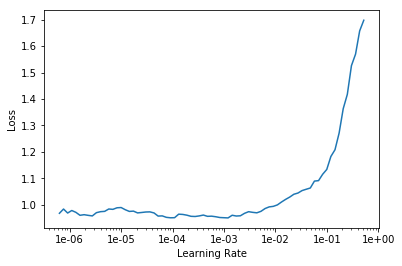

In [17]:
learn.lr_find()
learn.recorder.plot()

# Potholes in high dimensional space:

If you look at the training epochs below you will notice that the model hit a series of local minima on the way towards the optimal weights. I experimented with many combinations of weight decays, training cycles, learning rates, fine tuning, and the combination below worked the best. Even with these parameters the model still fumbles and falls on its face a little as it tries to find the optimal point.

Smaller learning rates kept getting stuck in local minima then overfitting, higher learning rates kept overshooting and getting worse without overfitting. Fine tuning the model by unfreezing it and retraining the early layers with a mild learning rate caused the error rate to go through the roof. Weight decay worked just fine at 1e-1, did some experimenting but the accuracy never got much higher than 80% with other weight decay settings. As a funny side note I tested this with multiple different models, and the learning rate curves optimal point stayed the same, but the steepness of the slope was different (the larger models had a flatter curve while the smaller models had a sharper one). 

In [18]:
learn.fit_one_cycle(17, max_lr=5e-4)

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.874884,0.782605,0.363281,0.617649,01:09
1,0.771261,0.647071,0.276367,0.719148,01:08
2,0.699604,0.728175,0.304688,0.682989,01:09
3,0.638618,0.898302,0.344727,0.642048,01:08
4,0.536434,1.010700,0.424805,0.545322,01:08
5,0.491024,1.687820,0.546875,0.434448,01:08
6,0.431374,1.234839,0.381836,0.578447,01:09
7,0.354306,1.509960,0.464844,0.524898,01:09
8,0.274750,0.289073,0.103516,0.896071,01:08
9,0.206989,0.781937,0.271484,0.709057,01:08


In [19]:
learn.save('checkpoint-3')

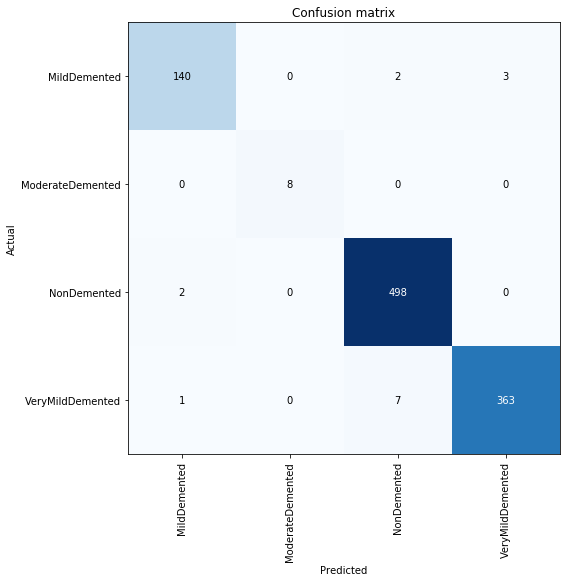

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)
interp.plot_confusion_matrix(figsize=(8,8))

# Test sets in FastAI

FastAI's data bunch doesn't attempt to compare test data with any labels, it assumes that the test set is only there to be labelled. As such, the cell below allows me to test the dataset on the test set and view the results. The results are output in an n+1 size list, where n refers to the number of evaluation metrics the model is given. I'm not sure what the first entry in the list does, each of the following entries are the scores of the model, output in the order in which they are received.

In [21]:
transform = get_transforms(max_rotate=7.5, max_zoom=1.15, max_lighting=0.15, max_warp=0.15, p_affine=0.8, p_lighting = 0.8, xtra_tfms= [pad(mode='zeros'), symmetric_warp(magnitude=(-0.1,0.1))])

In [22]:
data_test =  ImageDataBunch.from_folder(PATH,
                                  train="test/",#"train/",
                                  valid="test/",
                                  valid_pct=0.3,
                                  ds_tfms=transform,
                                  size=224,bs=32, 
                                  ).normalize(imagenet_stats)
ev = learn.validate(data_test.train_dl,metrics=[error_rate, FBeta(average='weighted')])
print('Results from test set \tError rate:', float(ev[1]), '\tF Beta Score: ', float(ev[2]))

Results from test set 	Error rate: 0.04933035746216774 	F Beta Score:  0.9504349231719971




 # Final Thoughts:

The goal of the Task was to hit an accuracy of 98% or greater, looks like the approach I chose to take just gets me to around 95% accuracy with an f_beta score of around .95 (Didn't set any random states so those number can be off by a percentage point or two when you rerun the notebook). The one nitpick about the model I have is that it will generate a small number of false negatives (the model would predict someone does not have alzheimers when they do).

In training and validation the model is able to get an accuracy score as high as 99% and an F_beta of around .98, however on test data the model is only able to achieve 95%. The final piece in getting this model's performance up is to focus on how to tone the overfitting down a smidge (In my personal experience, the best performing models are always slightly overfit). There is probably room for improvement with the transforms that I chose for the images. There may also be room for improvement by adding another resizing step or changing some of the dimensions in the current step. It's also possible that combining the results from this model with another would be necessary to close the gap for 98%.

As of 3/21/2020, this is the most accurate model for this dataset that I'm aware of (there aren't any public notebooks which beat this one's performance), this model still has room for improvement, but I'm happy with the results.

This year I've challenged myself to complete one task on Kaggle per week, in order to develop a larger Data Science portfolio. If you found this notebook useful or interesting please give it an upvote. I'm always open to constructive feedback. If you have any questions, comments, concerns, or if you would like to collaborate on a future task of the week feel free to leave a comment here or message me directly. For past TOTW check out the link to my page on github for this ongoing project
https://github.com/Neil-Kloper/Weekly-Kaggle-Task/wiki